## Loading

In [1]:
import os
import pathlib

import numpy as np

In [2]:
def load_data(data_dir):
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [3]:
import pandas as pd

In [4]:
data = load_data('/home/lzhu7/elvo-analysis/data/mip_three')
labels = pd.read_csv('/home/lzhu7/elvo-analysis/data/labels_mip_three.csv',
                     index_col='patient_id')

In [5]:
def to_arrays(data, labels):
    shuffled_ids = list(data.keys())
    np.random.shuffle(shuffled_ids)
    X_list = []
    y_list = []
    for id_ in shuffled_ids:
        X_list.append(data[id_])
        y_list.append(labels.loc[id_])
    return np.stack(X_list), np.stack(y_list)

In [6]:
x, y = to_arrays(data, labels)

In [7]:
from keras import (
    applications,
    layers,
    models,
    optimizers,
    callbacks,
    metrics,
    activations
)
from keras.preprocessing import image
from keras import backend as K

Using TensorFlow backend.
/gpfs/main/home/lzhu7/elvo-analysis/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Hack needed in order to load the model
metrics.sensitivity = sensitivity
metrics.specificity = specificity

In [9]:
model = models.load_model('weights1.hdf5')

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100, 100, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Visualization

In [11]:
%matplotlib inline

In [12]:
from matplotlib import pyplot as plt
from vis import visualization
from vis.utils import utils

In [13]:
# Swap softmax with linear
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

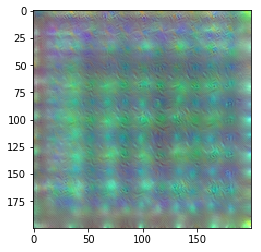

In [14]:
img = visualization.visualize_activation(model, -1, filter_indices=0)
plt.imshow(img)

In [ ]:
grads = visualization.visualize_saliency(model, -1, filter_indices=1, seed_input=x[0])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

In [ ]:
from quiver_engine import server

In [ ]:
# server.launch(model,
#               input_folder='/home/lzhu7/elvo-analysis/data/mip_three')

## Cifar-10

In [ ]:
from keras import datasets, utils

In [ ]:
batch_size = 32
num_classes = 10
epochs = 5
num_predictions = 20

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

In [ ]:
# initiate RMSprop optimizer
opt = optimizers.rmsprop(lr=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('Not using data augmentation.')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.imshow(x_train[0])